# Evaluating Ranking in Regression

In supervised learning regression problems, the focus is generally on metrics that ensure the predicted value is close to the true value of the sample. Classic regression metrics are variations that involve the measure $| \hat{y_i} - y_i |$.

However, it is not always essential to predict the exact value of the target variable precisely, as in some applications, exactness is not critical to the final objective. In many cases, achieving a good ranking of the predictions is sufficient to meet the demands of the business problem. Of course, this depends on the context, but with proper ranking, we can approach the problem similarly to setting a [threshold in binary classification](https://vitaliset.github.io/threshold-dependent-opt/) or, more generally, as a policy problem. In this case, the most appropriate cutoff point is identified through additional analysis to implement a desired treatment or action, such as targeting individuals with an expected credit card expense greater than $\delta$ for a new product marketing campaign. In most companies, the policy is structured around buckets of relevant percentiles, which are inherently based on ranking.

In other scenarios, such as income estimation, the regression model is often used as an auxiliary variable in subsequent models. These models, frequently ensemble of decision trees, inherently disregard the exact value of variables, considering only their rankings. If the final model is, for instance, a logistic regression or even a neural network, simple transformations are typically applied, altering the distribution of the values but maintaining monotonicity. Again, the exact values matter much less than the ranking.

From this perspective, it becomes clear that regression problems may require specific metrics to evaluate the quality of the ranking rather than relying solely on metrics that aim to minimize variations of $| \hat{y_i} - y_i |$.

___

To illustrate our metrics, let’s assume we built three different models that produced various scores for the same prediction problem, with the test set defined by `y_true`.

In [1]:
import numpy as np

random_state_0, random_state_1, random_state_2, random_state_3 = np.random.RandomState(42).randint(low=0, high=2**32 - 1, size=4)

y_true = np.random.RandomState(random_state_0).normal(size=1_000)

y_score_1 = np.exp(3 + y_true) + np.random.RandomState(random_state_1).normal(size=len(y_true))
y_score_2 = 3 * y_true + np.random.RandomState(random_state_2).normal(size=len(y_true))
y_score_3 = np.random.RandomState(random_state_3).normal(size=1_000)

SCORES = dict(zip(['y_score_1', 'y_score_2', 'y_score_3'], [y_score_1, y_score_2, y_score_3]))

Without delving into the specifics of how these scores were generated, the most natural and well-known way to evaluate these models would be using metrics such as $R^2$, $\textrm{MAE}$, or some variation of these. These metrics are very useful but do not necessarily provide much insight into ranking.

In our example, by analyzing the $\textrm{RMSE}$, it seems that `y_score_3` is a good predictor.

In [2]:
from sklearn import metrics

for score_name, y_score in SCORES.items():
    mae = np.sqrt(metrics.mean_squared_error(y_true=y_true, y_pred=y_score))
    print(f"MAE for {score_name}: {mae:6.3f}")

MAE for y_score_1: 58.205
MAE for y_score_2:  2.242
MAE for y_score_3:  1.400


___

## Spearman's Correlation

When we want to evaluate how a regression model ranks the data, it is natural to consider measures of correlation between two continuous variables. Consequently, an initial idea might be to use Pearson's correlation. However, Pearson's correlation focuses solely on linear relationships and does not account for the relative order of the values. Thus, even if the model accurately reproduces the order of the predicted values, if the transformation between the values is not close to linear, Pearson's correlation may not adequately reflect the quality of the ranking.

This is where Spearman's correlation ($\rho$) becomes an interesting metric, as it measures the similarity between the rankings of these variables [1]. In other words, it evaluates whether the order of the values is consistent between the two. This makes Spearman's correlation particularly useful in problems where the relative position of the values is more important than their magnitudes.

$\oint$ _Spearman's correlation can be seen as a version of Pearson's correlation applied to the ranks of the variables instead of their original values. Under the hood, Spearman transforms the data by replacing each value with its position in the ranking and then calculates Pearson's correlation on these ranks._

If there are no ties in the ranks, the simplified formula for Spearman's correlation is given by

$$ \rho = 1 - \frac{6 \sum_{i=1}^n d_i^2}{n(n^2 - 1)}, $$

where $n$ is the total number of observations, and $d_i$ is the difference between the ranks of the same observation in the two variables. To calculate $d_i$, we first assign a rank to each value of the variables. For example, given a set of values $\{w_i\}_{i=1}^n$ and $\{z_i\}_{i=1}^n$, we sort each set separately and replace the values with their respective ranks. Then, for each observation $i$, we compute

$$ d_i = \text{rank}(w_i) - \text{rank}(z_i). $$

The values of $\rho$ range between -1 and 1. A value of 1 indicates perfect ranking agreement, -1 indicates a complete inversion of the ranking, and 0 indicates no ranking relationship between the variables.

In [3]:
from scipy import stats

for score_name, y_score in SCORES.items():
    spearman = stats.spearmanr(y_true, y_score).statistic
    print(f"Spearman for {score_name}: {spearman:7.5f}")

Spearman for y_score_1: 0.99759
Spearman for y_score_2: 0.94718
Spearman for y_score_3: 0.01447


Using this new metric, we noticed that scores 1 and 2 stand out due to their ability of sorting `y_true`.

___

## Kendall's Tau Correlation

Another common metric for evaluating ranking is the Kendall's Tau ($\tau$) concordance index. This metric measures the strength of association between two rankings by comparing pairs of observations and determining whether they are concordant or discordant [2].

Two pairs $(w_i, z_i)$ and $(w_j, z_j)$ are considered:

- concordant: if the ranking of $w_i$ relative to $w_j$ is the same as the ranking of $z_i$ relative to $z_j$. Formally, this occurs when
$$ (w_i - w_j)(z_i - z_j) > 0. $$
- discordant: if the ranking of $w_i$ relative to $w_j$ is the opposite of that of $z_i$ relative to $z_j$. In other words,
$$ (w_i - w_j)(z_i - z_j) < 0. $$

The formula for Kendall's Tau is

$$\tau = \frac{C - D}{\frac{1}{2} n(n-1)},$$

where $C$ is the number of concordant pairs and $D$ is the number of discordant pairs. The denominator, $\frac{1}{2} n(n-1)$, represents the total number of possible pairs among $n$ observations.

Similar to Spearman's correlation, Kendall's Tau ranges between -1 and 1, with the same interpretation: when $\tau$ approaches 1, the rankings are highly concordant; when it approaches -1, the rankings are reversed; and when $\tau \approx 0$, there is no association between the rankings.

In [4]:
for score_name, y_score in SCORES.items():
    kendall = stats.kendalltau(y_true, y_score).statistic
    print(f"kendall's tau for {score_name}: {kendall:7.5f}")

kendall's tau for y_score_1: 0.96163
kendall's tau for y_score_2: 0.80227
kendall's tau for y_score_3: 0.00976


$\oint$ _It is possible to adapt the metric to account for sample weights by assigning the weight of a pair as the product of the weights of the samples._

___

## ROCAUC for Classification

ROCAUC for classification is a very good binary classification metric for measuring ranking [3]. It is a [class imbalance-invariant metric](https://pibieta.github.io/imbalanced_learning/notebooks/Metrics%201%20-%20Intro%20%26%20ROC%20AUC.html#proof-of-probabilistic-interpretation-of-the-roc-auc) and has a perfect interpretation for the ranking problem, being, in my experience, the primary metric used in the industry for binary classification problems when ranking is the primary goal.

It is possible to [prove](https://pibieta.github.io/imbalanced_learning/notebooks/Metrics%201%20-%20Intro%20%26%20ROC%20AUC.html#proof-of-probabilistic-interpretation-of-the-roc-auc) that in a binary classification problem with explanatory variables $X \in \mathcal{X}$ and $Y \in \{0, 1\}$, given a scoring/ranking function $f:\mathcal{X} \to \mathbb{R}$, then

$$\text{ROCAUC}(f) = \mathbb{P}\left( f(X_i) > f(X_j) \mid Y_i = 1, Y_j = 0 \right).$$

In other words, if we select a random sample from class 1 and a random sample from class 0 in our binary classification problem, the ROCAUC coincides with the probability that the score given to the class 1 sample is greater than the score given to the class 0 sample.

Because of this probabilistic interpretation of the metric, a good ROCAUC for your classifier is equivalent to a good ranking when using your classifier as a means of ordering.

___

## Estimating the ROCAUC via the Wilcoxon-Mann-Whitney statistic

The previous definition refers to the true ROCAUC value, rather than the estimated value we calculate using [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.roc_auc_score.html). In an observed random sample of $(X, Y)$, $\{(x_i, y_i)\}_{i=1}^n$, the probabilistic version can be estimated using the Wilcoxon-Mann-Whitney statistic as

$$ \frac{1}{n_0 n_1} \sum_{i : y_i = 1} \sum_{j : y_j = 0} \mathbb{1}\left( f(x_i) > f(x_j) \right), $$

where $n_0$ and $n_1$ are the numbers of elements in classes $0$ and $1$, respectively, and $\mathbb{1}\left(S\right)$ is the indicator function. $\mathbb{1}\left(S\right)$ is equal to 1 when the condition $S$ is true and 0 otherwise.

There are some variations of this statistic for more efficient computation, since in this form it requires a number of comparisons on the order of $\mathcal{O}(n_0 n_1)$, or $\mathcal{O}(n^2)$ if $n_1 \approx n_0$, which can be impractical [3]. The simplest basic version is to perform this sampling only a sufficiently large number $N$ of times, resulting in the version

$$\widehat{\text{ROCAUC}}(f) = \frac{1}{N} \sum_{(i,j) : y_i = 1, y_j = 0} \mathbb{1}\left( f(x_i) > f(x_j) \right).$$

## ROCAUC for Regression

This probabilistic interpretation motivates us to make an clever variation and use something similar for the regression problem [4]. If we replace the condition $y_i = 1, y_j = 0$ with $y_i > y_j$, we can construct a generic ranking probability metric for regression problems as

$$\widehat{\text{ROCAUC}}(f) = \frac{1}{N} \sum_{(i,j): y_i > y_j}  \mathbb{1}\left( f(x_i) > f(x_j) \right).$$

$\oint$ _Just like with Kendall's tau, it's possible to adapt the metric to account for sample weights by assigning the weight of a pair as the product of the weights of the samples._

In [5]:
from sklearn import utils

def regression_roc_auc(y_true, y_score):
    """Compute the generalized ROC AUC for regression tasks.

    This function calculates the probability that the predicted values maintain
    the correct order relative to the true values, specifically for pairs where
    y_true[i] > y_true[j].

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True continuous target values.

    y_score : array-like of shape (n_samples,)
        Predicted continuous target values.

    Returns
    -------
    score : float
        The computed generalized ROC AUC score for regression.
    """
    y_true = utils.check_array(y_true, ensure_2d=False, dtype=None)
    y_score = utils.check_array(y_score, ensure_2d=False)

    total_pairs = 0
    correct_orderings = 0

    # Efficiently compute the metric without explicit loops
    # Create a mask for all pairs where y_true[i] > y_true[j]
    diff_matrix = y_true[:, None] - y_true[None, :]
    valid_pairs = diff_matrix > 0

    # Count total valid pairs
    total_pairs = np.sum(valid_pairs)

    if total_pairs == 0:
        # If no valid pairs, return 0.5 (equivalent to random ordering)
        return 0.5

    # Compare predictions for valid pairs
    pred_diff = y_score[:, None] - y_score[None, :]
    correct_orderings = np.sum((pred_diff > 0) & valid_pairs)

    score = correct_orderings / total_pairs
    return score


In [6]:
for score_name, y_score in SCORES.items():
    roc_auc = regression_roc_auc(y_true, y_score)
    print(f"ROCAUC for {score_name}: {roc_auc:7.5f}")

ROCAUC for y_score_1: 0.98081
ROCAUC for y_score_2: 0.90113
ROCAUC for y_score_3: 0.50488


These metrics are quite useful, but if your regression problem is highly imbalanced, you may encounter some difficulties. I have worked on regression problems where over 99.5% of the data had values equal to 0, with only a small fraction having any associated value. Since many values will be tied, depending on the correlation implementation you use, your previous metrics may become artificially inflated or deflated, without a clear rationale to identify the issue. In the case of ROCAUC, with many ties in $y_i = y_j$, discarding numerous samples might result in a less reliable value with high variance.

___

## Ranking Curve

The ranking curve (I’m not sure if this curve has an official name) is interesting because it is very simple and intuitive. The process involves ranking your sample based on the predicted variable, dividing it into "buckets" according to percentiles, and then calculating the mean or another relevant positional statistic for each bucket. For example, if you divide the sample into 10 buckets, the third bucket would contain the elements with values falling between the 20th and 30th percentiles, and you would compute the mean of these values.

The idea is that, if your score ranks the sample well, then the elements with the highest values will cluster at one end, and those with the lowest values will cluster at the other. As a result, the resulting graph will have a steep slope.

$\oint$ _I usually divide the buckets into 10, but this number is a parameter you can adjust as desired, depending on the level of detail you want to observe. The issue is that the greater the detail, the noisier the result will be due to smaller sample sizes. However, by using a bootstrap method, you can plot a confidence interval for analysis._

$\oint$ _This construction is not a [QQ-plot](https://vitaliset.github.io/covariate-shift-1-qqplot/), but understanding how a QQ-plot works may help you grasp the construction of this metric, even though this curve is much simpler._

In [7]:
def ranking_curve(y_true, y_score, n_buckets=10, statistic='mean'):
    """Compute the ranking curve for a regression task.

    Calculates statistics of `y_true` values across `n_buckets`  of `y_score`
    values, ordered by the predicted scores. It can be used to  assess the
    distribution or trends of true values as a function of predicted scores.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True continuous target values.

    y_score : array-like of shape (n_samples,)
        Predicted continuous target values.

    n_buckets : int, default=10
        The number of buckets to divide the sorted `y_score` values into.

    statistic : {'mean', 'median'} or callable, default='mean'
        The statistic to compute for `y_true` values in each bucket.
        - If 'mean', computes the mean of `y_true` in each bucket.
        - If 'median', computes the median of `y_true` in each bucket.
        - If callable, applies the callable function to the `y_true` values in each bucket.

    Returns
    -------
    bucket_positions : ndarray of shape (n_buckets,)
        The positions of the buckets, indexed from 1 to `n_buckets`.

    bucket_values : ndarray of shape (n_buckets,)
        The computed statistic for `y_true` values in each bucket.
    """
    sorted_indices = np.argsort(y_score)
    y_true_sorted = y_true[sorted_indices]

    bucket_edges = np.linspace(0, len(y_true), n_buckets + 1, dtype=int)
    bucket_values = []

    if statistic == 'mean':
        stat_func = np.mean
    elif statistic == 'median':
        stat_func = np.median
    elif callable(statistic):
        stat_func = statistic
    else:
        raise ValueError

    for i in range(n_buckets):
        start, end = bucket_edges[i], bucket_edges[i + 1]
        bin_values = y_true_sorted[start:end]
        if len(bin_values) > 0:
            bucket_stat = stat_func(bin_values)
        else:
            bucket_stat = np.nan
        bucket_values.append(bucket_stat)

    bucket_positions = np.arange(1, n_buckets + 1)
    return bucket_positions, bucket_values

In [8]:
N_BUCKETS = 10
ordering_curve_dict = {}

for score_name, y_score in SCORES.items():
    bins, ordering_curve = ranking_curve(y_true, y_score, N_BUCKETS, 'mean')
    ordering_curve_dict[score_name] = ordering_curve

It’s useful to compare the curve with a random model that would uniformly distribute `y_true` across all bins, meaning that the mean for every bucket would be the same, as there would be no relationship between the order and `y_true`.

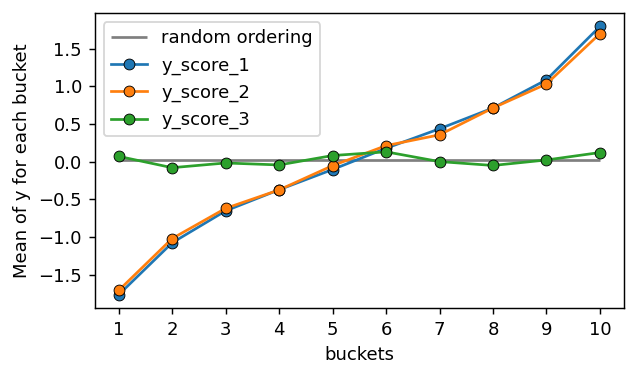

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 3), dpi=130)

ax.hlines(y_true.mean(), min(bins), max(bins), label='random ordering', colors='k', alpha=0.5)
for score_name, ordering_curve in ordering_curve_dict.items():
    ax.plot(bins, ordering_curve, '-o', markeredgecolor='k', markeredgewidth=0.5, label=score_name)

ax.set_xticks(bins)
ax.legend()
ax.set_ylabel("Mean of y for each bucket")
ax.set_xlabel("buckets")
plt.tight_layout()

It is also very useful to transform this plot into numerical values that can be used to compare models during hyperparameter optimization. Some of the metrics I like to use include:

- The value of the last bucket.  
- The value of the first bucket.  
- The difference between the last and the first bucket (which is equivalent to the mean of the variations through a telescoping sum).  
- The slope of a linear regression fitted to the points.  

In [10]:
def last_bucket_ordering_curve(y_true, y_score, n_buckets=10, statistic='mean'):
    _, ordering_curve = ranking_curve(y_true, y_score, n_buckets=n_buckets, statistic=statistic)
    *_, last_bucket = ordering_curve
    return last_bucket

def first_bucket_ordering_curve(y_true, y_score, n_buckets=10, statistic='mean'):
    _, ordering_curve = ranking_curve(y_true, y_score, n_buckets=n_buckets, statistic=statistic)
    first_bucket, *_ = ordering_curve
    return first_bucket

def diff_bucket_ordering_curve(y_true, y_score, n_buckets=10, statistic='mean'):
    _, ordering_curve = ranking_curve(y_true, y_score, n_buckets=n_buckets, statistic=statistic)
    first_bucket, *_, last_bucket = ordering_curve
    return last_bucket - first_bucket

from sklearn import linear_model

def linear_regression_coefficient_ordering_curve(y_true, y_score, n_buckets=10, statistic='mean'):
    _, ordering_curve = ranking_curve(y_true, y_score, n_buckets=n_buckets, statistic=statistic)
    x_values = np.arange(n_buckets).reshape(-1, 1)
    y_values = np.array(ordering_curve).reshape(-1, 1)

    model = linear_model.LinearRegression().fit(x_values, y_values)
    return model.coef_[0][0]


The higher the value of the last bin, the more concentrated the selected values of `y_true` are in the higher range.

In [11]:
for score_name, y_score in SCORES.items():
    last_bucket = last_bucket_ordering_curve(y_true, y_score)
    print(f"Last bucket for {score_name}: {last_bucket:7.5f}")

Last bucket for y_score_1: 1.79617
Last bucket for y_score_2: 1.70048
Last bucket for y_score_3: 0.12308


The lower the value of the first bin, the more concentrated the selected values of `y_true` are in the lower range.

In [12]:
for score_name, y_score in SCORES.items():
    first_bucket = first_bucket_ordering_curve(y_true, y_score)
    print(f"First bucket for {score_name}: {first_bucket:8.5f}")

First bucket for y_score_1: -1.76345
First bucket for y_score_2: -1.70674
First bucket for y_score_3:  0.07232


The greater the difference between the last bin and the first bin, the better separated the values with low scores are from those with higher scores.


In [13]:
for score_name, y_score in SCORES.items():
    diff_bucket = diff_bucket_ordering_curve(y_true, y_score)
    print(f"Diff bucket for {score_name}: {diff_bucket:7.5f}")

Diff bucket for y_score_1: 3.55962
Diff bucket for y_score_2: 3.40723
Diff bucket for y_score_3: 0.05076


The steeper the slope of the linear regression curve fitted to the points, the more tilted the points are, indicating better ranking.

In [14]:
for score_name, y_score in SCORES.items():
    lr_bucket = linear_regression_coefficient_ordering_curve(y_true, y_score)
    print(f"Linear regression coefficient for {score_name}: {lr_bucket:7.5f}")

Linear regression coefficient for y_score_1: 0.34367
Linear regression coefficient for y_score_2: 0.32808
Linear regression coefficient for y_score_3: 0.00722


$\oint$ _Adding sample weights to this curve is considerably more tedious, as you need to split the percentiles based on the sum of the weights, [but it’s not impossible](https://github.com/dihanster/datalib/issues/17#issue-1688825236). :)_

$\oint$ _This curve is also really good for evaluating ranking performance for classification problems._

___

## Final considerations

Although regression models often optimize metrics based on $|\hat{y_i} - y_i |$, I hope this discussion has inspired reflection on the limitations of such metrics. They may not always be the most appropriate choice and can sometimes obscure the true problem of interest.

The ranking metrics introduced here each provide are highly valuable, complementing one another depending on the specific context and problem at hand. Instead of striving for a single, universally applicable metric, it is often more effective to evaluate these metrics collectively. In practice, they tend to align and reinforce each other, offering a richer and more nuanced understanding of model performance.

Moreover, I encourage you to tweak existing metrics or develop custom variations which can often uncover fresh perspectives on a problem. The ultimate goal is not merely to assign a score to a model but to ensure it aligns with the problem's objectives and delivers outcomes that are meaningful and actionable.

$\oint$ _It is worth emphasizing that ranking-oriented metrics are especially relevant in domains like recommendation systems, where the primary objective is to provide an optimal ranking of items rather than precise predictions. By focusing on ranking quality, these metrics address the practical requirements of systems designed to prioritize user preferences and deliver highly relevant outcomes efficiently. I believe that adaptations of such metrics could also be highly effective for addressing the challenges in other domains._

## Bibliography

[1] [Spearman's rank correlation coefficient. Wikipedia.](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)

[2] [Kendall rank correlation coefficient. Wikipedia.](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient)

[3] [Imbalanced Binary Classification - A survey with code. Alessandro Morita, Juan Pablo Ibieta, Carlo Lemos.](https://pibieta.github.io/imbalanced_learning/notebooks/Introduction.html)

[4] [You Can Compute ROC Curve Also for Regression Models. Samuele Mazzanti.](https://towardsdatascience.com/how-to-calculate-roc-auc-score-for-regression-models-c0be4fdf76bb)